In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# The ML basic: Linear regression

In [10]:
# The data is somehow given by the gods of data collection. 
# Say we've measured the time and the coordinate of the ball rolling with no friction
noise_power = 5
N = 100
x = np.random.rand(N) * 10
noise = np.random.randn(N) * noise_power + np.random.rand(N)
y = x * 0.8 + noise
# y[:len(y)//2] = x[:len(y)//2] * 0.4 + noise[:len(y)//2]

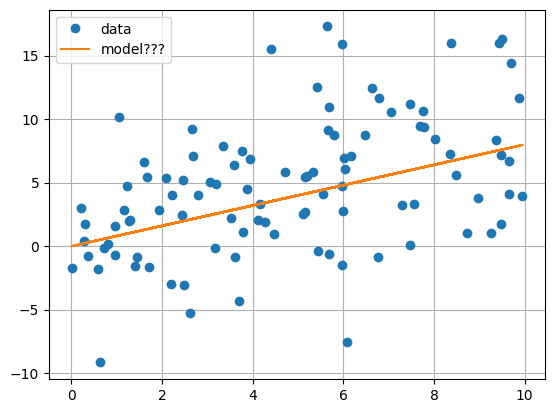

In [11]:
plt.plot(x, y, "o", label='data')
plt.plot(x, x * 0.8, label='model???')
plt.grid()
plt.legend()

We aim to model the data with an *y = f(x) = wx + b* function.

However, we do not know *w* and *b*. Let's find the ones which better suit the data!

Optimal w = 0.939


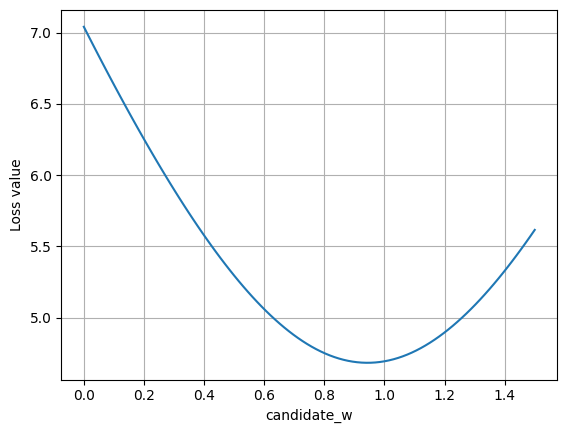

In [12]:
def mse_loss_function(y_pred, y):
    """
    Define the fitting quality mean squared error
    """
    return np.sqrt(np.mean((y_pred - y) ** 2))
# grid search
candidate_w = np.linspace(0, 1.5, 100)
losses = []
for w in candidate_w:
    y_sample = x * w
    losses.append(mse_loss_function(y_sample, y))
plt.plot(candidate_w, losses)
plt.grid()
plt.xlabel("candidate_w")
plt.ylabel("Loss value")
print(f"Optimal w = {round(candidate_w[np.argmin(losses)], 3)}")

We've found the optimal *w* by the bruteforce search. That works. 

However, we should find a more effective method to find the optimal *w* before the police sees this.

To this end, note that *mse_loss_function* is **CONVEX** (one can prove that, but just look at the graph of the loss function). 

This means that we may just find the local optimum by zeroing the derivative and that will be the global minimum. 

loss = (wx + b - y) ** 2 =>

x.T * (wx + b - y) = 0

wx + b - y = 0

(check out https://en.wikipedia.org/wiki/Linear_regression)

[0.65331654 0.55773905]


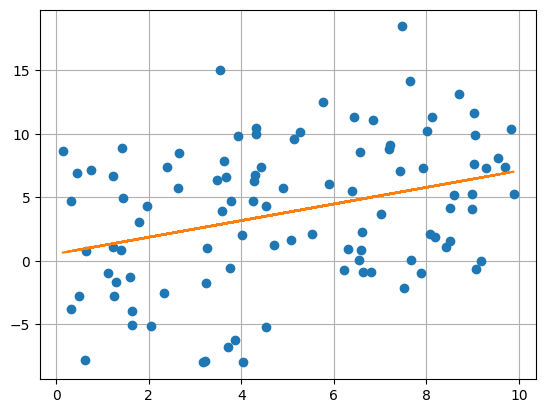

In [8]:
params = np.polyfit(x, y, 1)
print(params)
plt.plot(x, y, "o", label='data')
plt.plot(x, params[0] * x + params[1], "--", label='model')
plt.grid()

[0.65331654] 0.5577390458885159


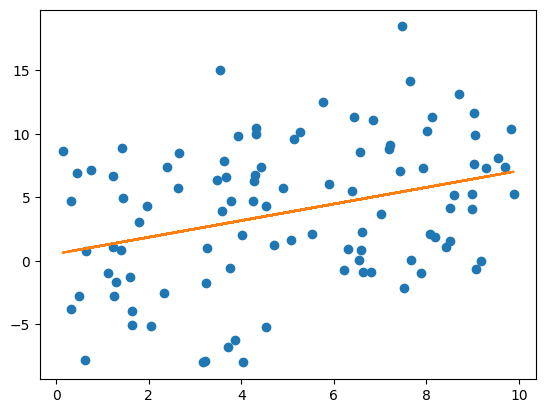

In [9]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)
pred = reg.predict(x.reshape(-1, 1))
print(reg.coef_, reg.intercept_)
plt.plot(x, y, "o")
plt.plot(x, pred)

N\b: how to turn the linear regression to classification?

# What if the model is not convex? 
### Like, need to fit a sinus function

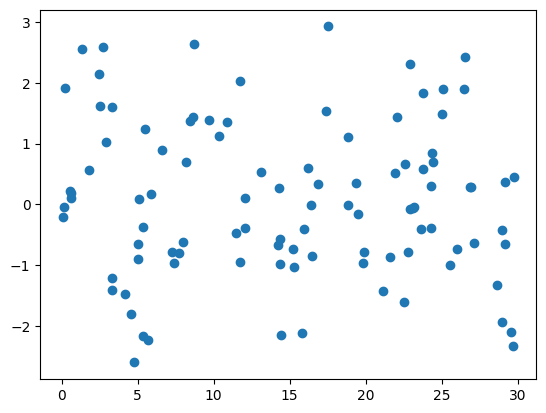

In [13]:
noise_power = 1
N = 100
x_sinus = np.random.rand(N) * 30
noise = np.random.randn(N) * noise_power
y_sinus = np.sin(x_sinus * 0.8) + noise
plt.plot(x_sinus, y_sinus, "o")

Optimal w = 0.803


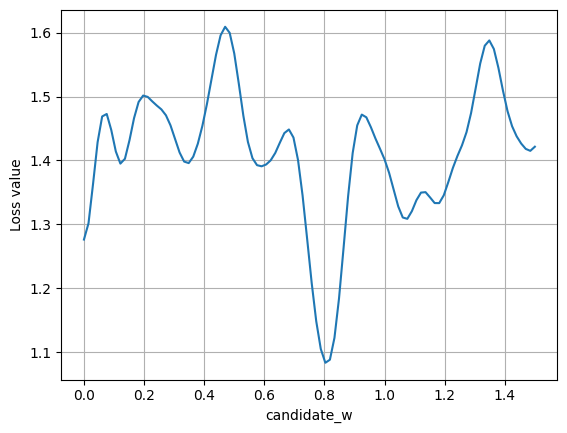

In [14]:
candidate_w = np.linspace(0, 1.5, 100)
losses = []
for w in candidate_w:
    y_sample = np.sin(x_sinus * w)
    losses.append(mse_loss_function(y_sample, y_sinus))
plt.plot(candidate_w, losses)
plt.grid()
plt.xlabel("candidate_w")
plt.ylabel("Loss value")
print(f"Optimal w = {round(candidate_w[np.argmin(losses)], 3)}")

Theoretically, we should not be optimizing arbitrary nonconvex functions using a gradient descent. In the nonconvex case, gradient descent does not guarantee finding a global optimum. 

We only find a LOCAL minimum using this method.

However, the global optimization methods become too costy when we fit a ~million parameters. Moreover, the local minimum might be sufficient. For these reasons, the neural network optimizers use the gradient descent.

There are numerous heuristics in the ML frameworks that allow to 'jump' between the local minimums to find the best and the deepest one. 

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=500, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
for i in range(5, 20):
    clf = MLPClassifier(hidden_layer_sizes=(i, ), activation='relu', solver='adam', 
                        random_state=1, max_iter=300, batch_size=10, learning_rate_init=0.01,
                        learning_rate='constant').fit(X_train, y_train)
    pred = clf.predict_proba(X_test)
    print(i, clf.score(X_test, y_test))

5 0.904
6 0.92
7 0.904
8 0.944
9 0.928
10 0.888
11 0.912
12 0.92
13 0.896
14 0.912
15 0.912
16 0.912
17 0.904
18 0.912
19 0.912


# Convolutional neural networks

What's a convolution?

In [32]:
import torch
import torch.nn.functional as F
x = torch.Tensor([1,2,3,4,5,6,7,8]).float().reshape(1,1,-1)
weight = torch.Tensor([1,1,0]).reshape(1,1,3).float()
print(x.shape, weight.shape)

F.conv1d(x, weight, padding=1)

torch.Size([1, 1, 8]) torch.Size([1, 1, 3])


tensor([[[ 1.,  3.,  5.,  7.,  9., 11., 13., 15.]]])

### What a convolution can do?

N\b: is there a convolution for the differentiation operator? For removing the trend?

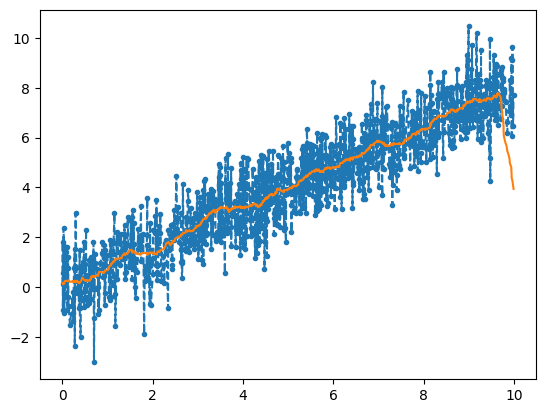

In [253]:
N = 1024
x = np.random.rand(N) * 10
noise = np.random.randn(N) * noise_power
x = np.sort(x)
y = x * 0.8 + noise
plt.plot(x,y,".--")
y_pt = torch.from_numpy(y).reshape(1,1,-1).float()
N_weight = 51
weight = torch.Tensor([1]*N_weight).reshape(1,1,-1).float() / N_weight
y_filt = F.conv1d(y_pt, weight, padding=weight.shape[-1]//2).squeeze().numpy()
plt.plot(x, y_filt)

### The Fourier spectrum viewpoint on convolutions

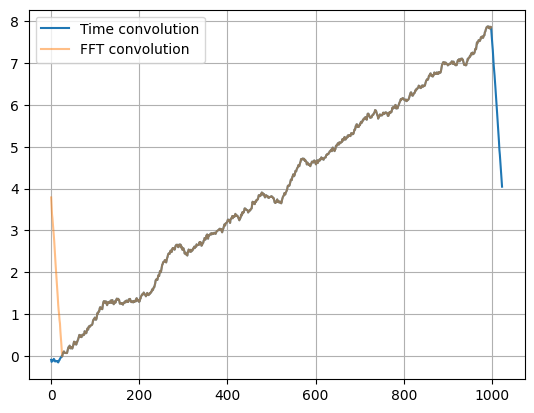

In [214]:
from scipy import fftpack

weight = torch.Tensor([1]*N_weight).reshape(1,1,-1).float() / N_weight
y_filt = F.conv1d(y_pt, weight, padding=weight.shape[-1]//2).squeeze().numpy()
plt.plot(y_filt, label='Time convolution')
weight_np = weight.squeeze().numpy()
weight_spec = fftpack.fft(weight_np, n=len(y))
y_spec = fftpack.fft(y, n=len(y))
y_spec_filt = y_spec * weight_spec
y_fft_filt = fftpack.ifft(y_spec_filt).real
plt.plot(y_fft_filt[N_weight//2:], alpha=0.5, label='FFT convolution')
plt.legend()
plt.grid()

### How the pattern matching with the convolution works?

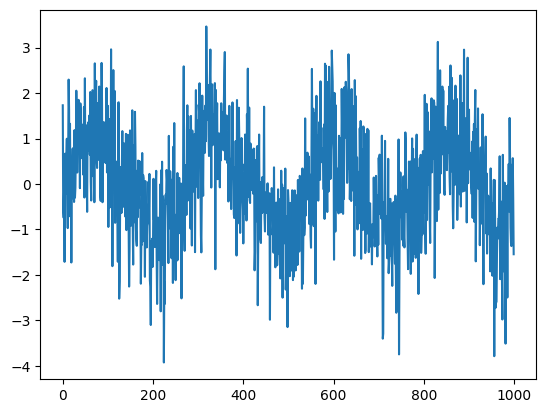

In [223]:
noise_power = 1
N = 1000
x_sinus = np.random.rand(N) * 30
x_sinus=np.sort(x_sinus)
noise = np.random.randn(N) * noise_power
carrier_signal = np.sin(x_sinus * 0.8)
y_sinus = carrier_signal + noise
plt.plot(y_sinus)

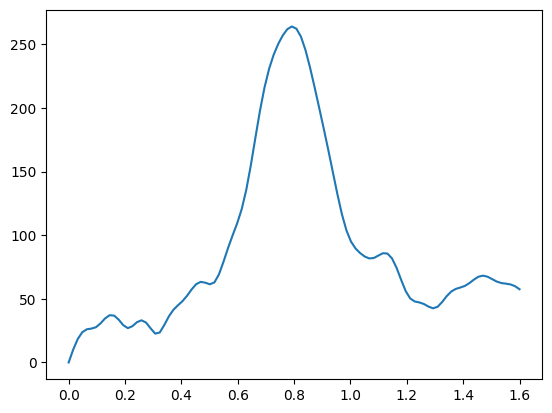

In [224]:
possible_ws = np.linspace(0,1.6,100)
powers = []
for w in possible_ws:
    carrier_signal = np.sin(x_sinus * w)
    convolved = F.conv1d(torch.from_numpy(y_sinus.reshape(1,1,-1)), torch.from_numpy(carrier_signal.reshape(1,1,-1)),
                         padding=len(y_sinus)//2).squeeze().numpy()
    powers.append(convolved.std())
plt.plot(possible_ws, powers)

# Practiсe \ Howework

### Task
Build a classifier based on CIFAR100 (https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR100.html#torchvision.datasets.CIFAR100). This classifier must distinguish between bicycle, motorcycle and the background.

To this end, leverage an ImageNet-pretrained model and modify the last layer (https://pytorch.org/vision/0.8/models.html).
Use any architecture of your choice, it does not matter.

### Features
**7\10 base**: complete this task.

**+1 point**: leverage 5 augmentations (https://pytorch.org/vision/stable/transforms.html).


**+1 point**: play around with hyperparameters.


**+2 points**: say, we want to use this classifier in the wild and we need it to be stable in a dark environment.
To this end, we wanna use IR cameras with the invisible IR flashes. However, such cameras stream images in grayscale.

We want to leverage the opensource RGB datasets for this task.

=> Make a grayscale model.


### Advanced H\w: learn how to fool around with the weights as they were some usual numpy arrays
**+1 point**: say we are making a grayscale model and we want to minimize the training. Our dataset is very small, Imagenet is very large, we want to keep as much ImageNet information as possible to improve generalization. 

The first layer in the PyTorch ImageNet RGB checkpoint has 3 RGB channels, right? Modify this layer in a rule-based fashion to have 1 grayscale channel as an input and transform the features in the most correct way.

(*Spoiler alert*: the 1 input grayscale channel should be a linear combination of the 3 RGB channels)

**+2 points**: say we have some Chineese experimental on-board device that only can compute Conv3d effectively but not Conv2d. Or we just know that a Conv3d backend works faster on our target device. Or we plan that this model would accept videos in the future and we want to prepare a Conv3d backend. In short, we have our reasons to do the following.

Transform the model so that at least some Conv2d layers use a Conv3d backend leveraging the pretrained weights.#

Max points number for H\w is 10.

Deadline 8.12 23:59

In [256]:
import torchvision

In [263]:
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [266]:
w = resnet.state_dict()['conv1.weight']
w.shape, w.std(), w.mean()

(torch.Size([64, 3, 7, 7]), tensor(0.1232), tensor(-0.0005))